# Usando clusterização para decidir onde morar

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Mapa_de_Jo%C3%A3o_Pessoa_e_regi%C3%B5es_pr%C3%B3ximas.jpg/735px-Mapa_de_Jo%C3%A3o_Pessoa_e_regi%C3%B5es_pr%C3%B3ximas.jpg)

Em 2023 entrei no regime 100% Home Office, nesse contexto decidir por escolher uma cidade que pudesse me atender melhor nas coisas que desejava na vida, depois de testar morar por  alguns lugares no Brasil ao longo desse ano decidi que esse lugar iria ser João Pessoa na Paraíba. Agora eu tinha que enfim alugar um apartamento...

>... **mas morar onde? Baseado em que eu faria essa decisão? Do que eu preciso perto desse lugar para atender as minhas necessidades cotidianas?**

A resolução desse problema é o que vocês verão na sequência.

A proposta de resolução passa pelas seguintes etapas:

- Coleta de dados. Através dos pacotes osmnx e googlemaps (API python do Google Maps), coletando as informações de limites geográficos da cidade (ruas e afins) e os pontos de interesse (Facilities), respectivamente.
- Seccionar os limites geográficos em hexágonos  e interseccionar com os pontos comerciais de interesse.
- Contabilizar  esses pontos de interesse por hexágono e ponderar a minha importância pessoal para cada tipo deles.
- Clusterizar essa tabela de pontos de interesse ponderados e decidir dentre uma lista de endereços de interesse as melhores regiões.

# Imports

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
# import googlemaps
# import folium

# Funções

Para deixar as coisas mais organizadas e objetivas eu montei uma série de funções (process.py) que foram responsáveis pela coleta e o processamento geográfico, se essa parte for do seu interesse eu tive o cuidado de deixar o que cada uma faz da forma mais clara e documentada o possível. Dentre elas a obtenção  da chave para usar a API do Google Maps é a que julguei que pode precisar de um pouco mais de empenho, a coleta não é a principal questão que quero abordar hoje, porém vou deixar esse [link](https://developers.google.com/maps/documentation/places/web-service/overview) para você explorar e você vai precisar ter uma conta no [serviço de Cloud do Google](https://cloud.google.com) para prosseguir, mas deixei disponível no repositório os arquivos que obtive na minha análise.

In [2]:
from process import (
                     create_geo_address , #Cria um GeoDataFrame a partir de uma lista de endereços.
                     create_geo_objects_city, #Cria arquivos geográficos através do nome de uma cidade indicada
                     facilities_for_locates_range, #Busca estabelecimentos em API e retorna um geodataframe com todas as informações coletadas.
                     make_hexagons,#Função para gerar regiões em hexágonos
                     evaluate_gini_clusters #Avalia o índice de Gini para cada feature em cada cluster e retorna um DataFrame com estatísticas adicionais
                     )

# Carregando dados geográficos

## Carregando grafo e área de João Pessoa, Paraíba, Brazil

In [3]:
place_name = "João Pessoa, Paraíba, Brazil"
nodes_proj, edges_proj, area = create_geo_objects_city(place_name)

## Carregando lista de endereços de interesse
Aqui eu peguei um lista de endereços de alguns imóveis que achei interessante.

In [4]:
enderecos = ["Rua Irapuan Vasconcelos Leitão da Cunha, Portal do Sol - João Pessoa, PB",
             "Rua Artur Enedino dos Anjos, Altiplano Cabo Branco - João Pessoa, PB",
             "Rua Moema Palmeira Sobral, Tambauzinho - João Pessoa, PB",
             "Avenida Campos Sales, Bessa - João Pessoa",
             "Rua Adalgisa Luna de Menezes, Bancários - João Pessoa"]
enderecos_gpd = create_geo_address(enderecos)
enderecos_gpd

,index,Endereços,geometry
0,0,"Rua Irapuan Vasconcelos Leitão da Cunha, Porta...",POINT (-34.82029 -7.14415)
1,1,"Rua Artur Enedino dos Anjos, Altiplano Cabo Br...",POINT (-34.82981 -7.13633)
2,2,"Rua Moema Palmeira Sobral, Tambauzinho - João ...",POINT (-34.84638 -7.12416)
3,3,"Avenida Campos Sales, Bessa - João Pessoa",POINT (-34.83756 -7.07287)
4,4,"Rua Adalgisa Luna de Menezes, Bancários - João...",POINT (-34.83395 -7.14516)


## Criando Hexágonos

In [5]:

df_centroides_hex , df_hex = make_hexagons(area)

c:\WIMYD\choosen_house\process.py:214: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_hex['geometry'] = df_hex[final_hex_col]\
c:\WIMYD\choosen_house\process.py:224: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroides_hex = df_hex['geometry'].centroid


## Facilities por Google Maps API

Existem uma infinidade de tipos de lugares de interesse, eu listei apenas os 5 principais para mim, o critério principal da escolha destes é que eu preciso acessa-los pelo menos uma vez por semana. Para saber quais os tipos disponíveis na API do Google maps você pode ver esse [link](https://developers.google.com/maps/documentation/places/web-service/place-types). 

**IMPORTANTE!!! ISSO PODE TER CUSTOS DE USO DA API SE EXCEDER O LIMITE DE REQUISIÇÕES POR DIA OU MINUTO,** você pode usar os arquivos pré baixados no repositório


In [6]:
types = [
         'supermarket',
         'bakery',
         'restaurant',
         'gym',
         'park',
         'pharmacy'
         ]

# with open('./data/key.json', 'r') as f:
#     key = json.load(f)['key']

# full_places_city = facilities_for_locates_range(types= types, df_gpd=df_centroides_hex , index_gpd='hex8', key=key , geometry_col='geometry')
# full_places_city = full_places_city.reset_index(drop=True)
# full_places_city = full_places_city.rename(columns={"place_index":"index"})
# full_places_city["X"] = full_places_city["geometry"].x
# full_places_city["Y"] = full_places_city["geometry"].y

#----------------------------------------------------------------------------
# with open('./data/full_places_city.json', 'w') as f:
#   f.write(full_places_city.to_json())

full_places_city = gpd.read_file('./data/full_places_city.json')

# Interseccionando Facilities com Hexágonos

In [7]:
#Interseccionando
full_places_city_select = full_places_city[full_places_city.geometry.within(df_hex.unary_union)]
full_places_city_select = full_places_city_select.rename(columns={"index":"hex8_code"})

#Contabilizando os pontos de interesse por hexagono
hex_count_facilities = full_places_city_select[['hex8_code','main_type','place_id']]\
    .groupby(['hex8_code','main_type'],as_index=False)\
    .count()\
    .rename(columns={"place_id":"count"})
hex_count_facilities = hex_count_facilities.pivot_table(index='hex8_code',
                                                        columns='main_type',
                                                        values='count',
                                                        fill_value=0)\
                                            .reset_index()
hex_count_facilities.columns = [i for i in hex_count_facilities.columns]

# Dando pesos para os Facilities de cada Hexágono

Na cidade existem bairros que tem alta concentração de alguns desse pontos de interesse, um lugar que tem shopping no bairro por exemplo tem muitos restaurantes, porém isso não é importante para o contexto da nossa analise, já que por mais que uma área tenha 10 ou 20 restaurantes na prática eu vou pensar em 5 e frequentar de fato uns 2. Por isso ajustei as contagens para considerar no máximo 5 itens de cada, o que vai ajudar a normalizar a escala dessas variáveis para os pesos que serão aplicados.

In [8]:
def replace_name(x):
    return x.replace('bakery','padaria')\
    .replace('gym','academia')\
    .replace('pharmacy','farmácia')\
    .replace('restaurant','restaurante')\
    .replace('supermarket','supermercado')
    
gym_weight = 0.3
restaurant_weight = 0.25
supermarket_weight = 0.25
bakery_weight = 0.1
park_weight = 0.05
pharmacy_weight = 0.05

range = 5
for i in types:
  hex_count_facilities[i+"_aj"] = hex_count_facilities[i]\
                                    .apply(lambda x: range if x>range else x)

hex_count_facilities['weighted_avg'] = (
    hex_count_facilities
    .apply(lambda x: (x['bakery_aj']/range * bakery_weight) \
           + (x['gym_aj']/range * gym_weight) \
           + (x['park_aj']/range * park_weight) \
           + (x['pharmacy_aj']/range * pharmacy_weight) \
           + (x['restaurant_aj']/range * restaurant_weight) \
           + (x['supermarket_aj']/range * supermarket_weight),
           axis=1)
)

df_hex_select = df_hex.merge(hex_count_facilities,left_on="hex8",right_on="hex8_code")\
                      .drop(columns=['hex8'])
                      
df_hex_select.columns = [ replace_name(col) for col in df_hex_select.columns]

full_places_city_select['main_type'] = full_places_city_select['main_type']\
                                            .apply(lambda x: replace_name(x))

types = [replace_name(col) for col in types]

C:\Users\chpsi\AppData\Local\Temp\ipykernel_217580\2141773696.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


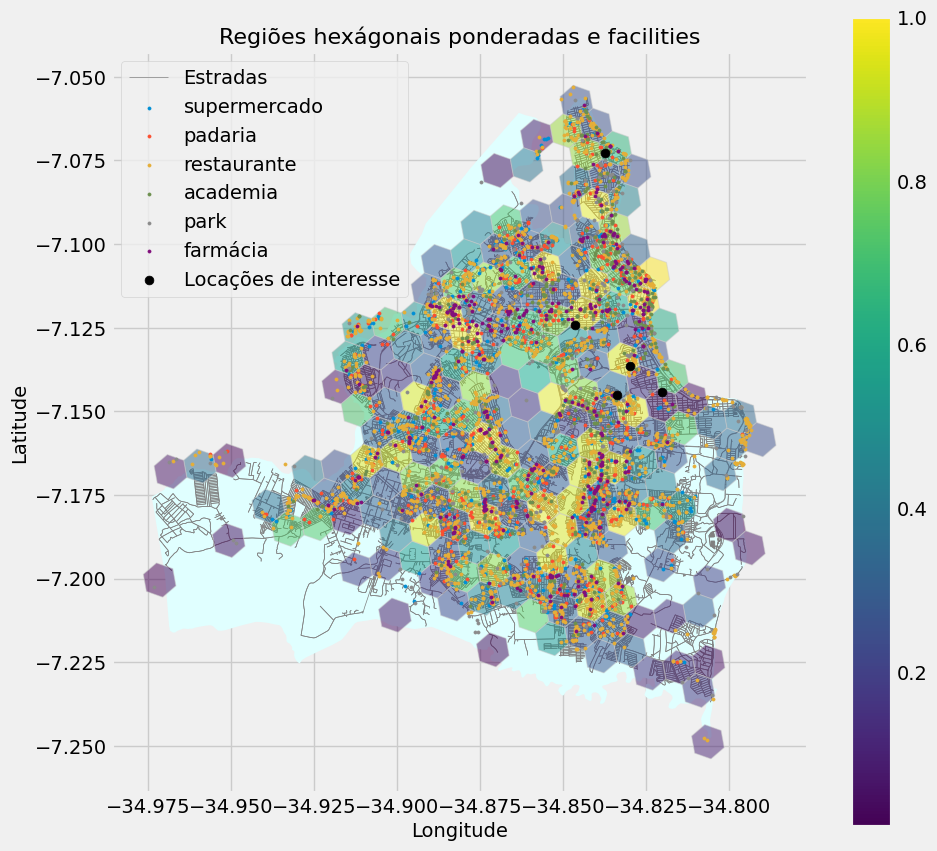

In [9]:
plt.style.use('fivethirtyeight')
vmin, vmax = df_hex_select['weighted_avg'].min(), df_hex_select['weighted_avg'].max()
cmap = 'viridis' 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
area.plot(ax=ax , color='lightcyan', linewidth=1, label='Area',zorder=1)
edges_proj.plot(ax=ax , color='gray', linewidth=0.5, label='Estradas',zorder=1)
df_hex_select.plot(column='weighted_avg', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax , alpha=0.5)
for type_plot_place in types:
  full_places_city_select[full_places_city_select['main_type']==type_plot_place].plot(ax=ax , linewidth=0.5, label=type_plot_place,zorder=1 , markersize=5)

enderecos_gpd.plot(ax=ax , color='black', linewidth=0.5, label='Locações de interesse',zorder=1 , markersize=40)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
plt.title('Regiões hexágonais ponderadas e facilities', size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)
plt.legend()
plt.show()


# Cluster

Existem uma grande variedade de tipos de clusterização, na [documentação](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) do scikit-learn é apresentada um breve resumo de algumas delas. Um algoritmo de Cluster amplamente conhecido e simples é o K-Means, ele trabalha melhor em geometria plana (duas dimensões) e com pouca quantidade de clusters, para conseguir usá-lo vai vou reduzir a quantidade de features usando o método de PCA ([Principal component analysis](https://en.wikipedia.org/wiki/Dimensionality_reduction)).

In [10]:
# Os mesmos  que foram usados para capturar os dados na API do Google
cluster_variables =[i+"_aj" for i in types] 
df_cluster = df_hex_select[cluster_variables]
df_cluster.describe()

,supermercado_aj,padaria_aj,restaurante_aj,academia_aj,park_aj,farmácia_aj
count,199.000000,199.000000,199.000000,199.000000,199.00000,199.000000
mean,1.648241,1.989950,4.271357,1.592965,1.21608,1.301508
std,2.080910,2.190406,1.549433,2.020139,1.71992,1.948723
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,5.000000,0.000000,0.00000,0.000000
50%,0.000000,1.000000,5.000000,0.000000,0.00000,0.000000
75%,3.500000,5.000000,5.000000,3.000000,2.00000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000


## Redução de dimensionalidade - PCA

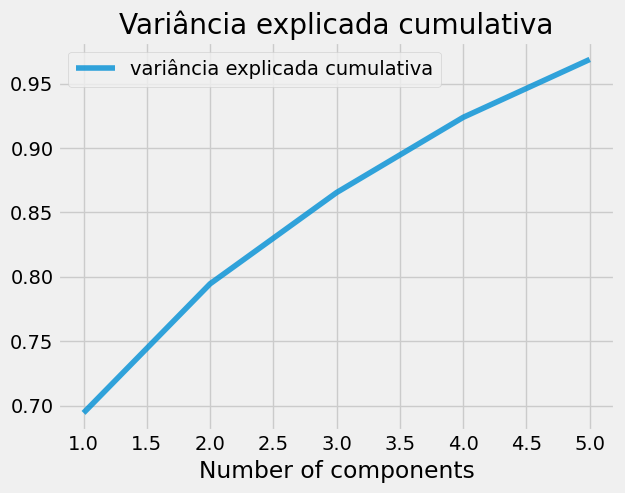

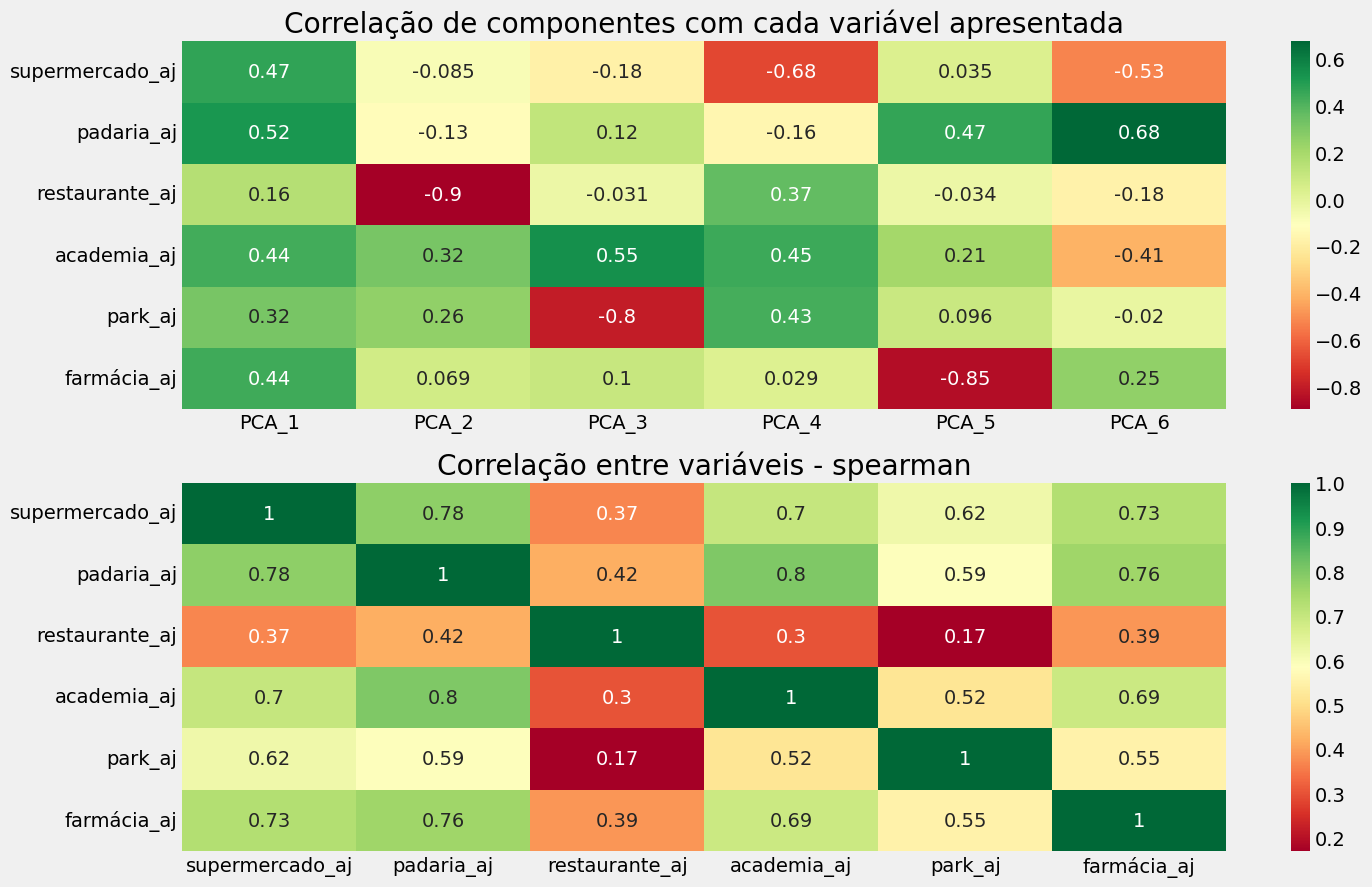

In [11]:
from sklearn.decomposition import PCA

clusters_df = df_cluster.reset_index(drop=True)

# Aplicando o PCA
n_components = len(clusters_df.columns)
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(clusters_df)

#Montando tabela de variância explicada 
exp_variance = pca.explained_variance_ratio_
df_variance = pd.Series(exp_variance, name="explained variance")
df_cum_variance = pd.Series(
    np.cumsum(exp_variance), name="variância explicada cumulativa"
)
df_comp = pd.Series(np.arange(1, clusters_df.shape[1]), name="Number of components")
pca_df = pd.concat([df_variance, df_cum_variance, df_comp], axis=1)

#Montando tabela de correlação entre os componentes e as variáveis
pca_cols = ["PCA_" + str(i) for i in list(np.arange(1, n_components + 1))]

componentesTable = pd.DataFrame(
    pca.components_.T,
    index=clusters_df.columns,
    columns=pca_cols
)

################################################################################
pca_df.plot(kind='line',
            y='variância explicada cumulativa',
            x='Number of components',
            alpha=.8)
plt.title('Variância explicada cumulativa')
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10), sharey=True)

ax1.set_title("Correlação de componentes com cada variável apresentada")
sns.heatmap(
    componentesTable,
    annot=True,
    cmap="RdYlGn",
    ax=ax1,
)

ax2.set_title("Correlação entre variáveis - spearman")
sns.heatmap(
    round(clusters_df.corr(method="spearman"), 2),
    annot=True,
    cmap="RdYlGn",
    ax=ax2,
)

plt.show()

## Selecionando a quantidade de Clusters
# Métricas de Agrupamento e Separação
[**Silhueta**](https://en.wikipedia.org/wiki/Silhouette_(clustering))

A silhouette é um método de interpretação e validação de consistência dentro de grupos de dados. A silhueta é uma medida de quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação a outros clusters (separação) . **A silhueta varia de -1 a +1, onde um valor alto indica que o objeto é bem compatível com o seu próprio cluster e mal combinado com os clusters próximos**. Se a maioria dos objetos tiver um valor alto, a configuração do cluster será apropriada. Se um número significativo de pontos tiver um valor baixo ou negativo, a configuração do cluster pode ter muitos ou poucos clusters.

[**Distorção**](https://marcusvd.medium.com/k-means-como-algoritmo-de-agrupamento-e-identifica%C3%A7%C3%A3o-de-padr%C3%A3o-em-grupos-2c311007718f)

A distorção é uma métrica de avaliação de clusters que mede a qualidade de um agrupamento de dados. Ela calcula a soma das distâncias quadradas entre cada ponto de dados e seu centroide mais próximo. Um valor de distorção **menor indica um agrupamento melhor**, pois significa que os pontos de dados estão mais próximos de seus centroides.


[**Calinski-Harabasz**](https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/)

O índice Calinski-Harabasz (também conhecido como critério de razão de variância ) é uma medida de quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Aqui, a coesão é estimada com base nas distâncias dos pontos de dados em um cluster até o centroide do cluster e a separação é baseada na distância dos centroides do cluster do centroide global. **Um valor mais alto do índice CH significa que os clusters são densos e bem separados, embora não haja um valor de corte “aceitável”.** 
___
Em geral precisamos escolher aquela solução que dá um pico ou pelo menos um cotovelo abrupto no gráfico. Por outro lado, se a linha for suave (horizontal ou ascendente ou descendente), não há razão para preferir uma solução em detrimento de outras.

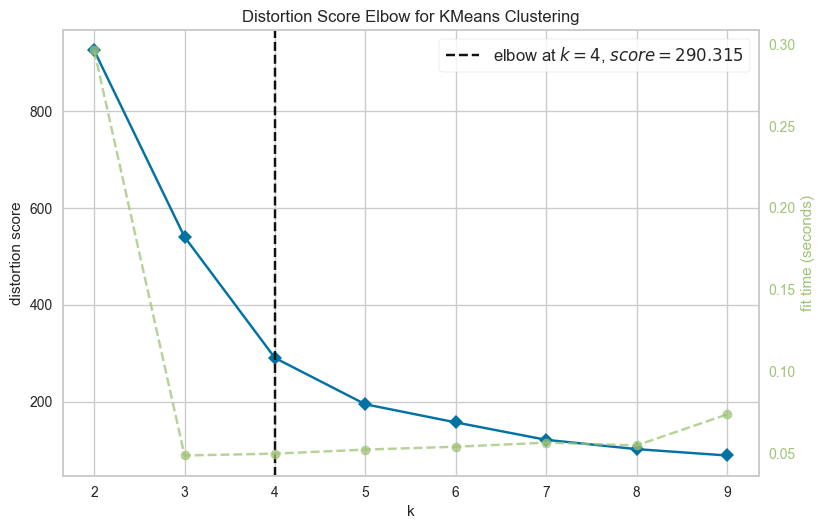

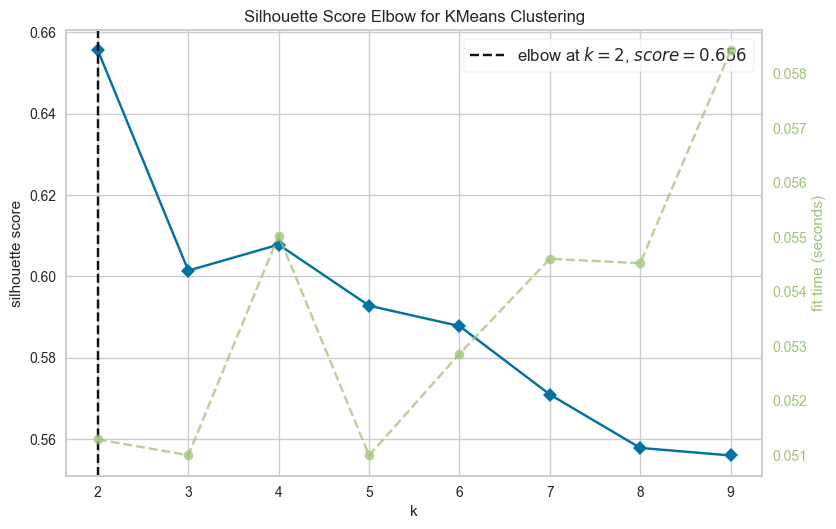

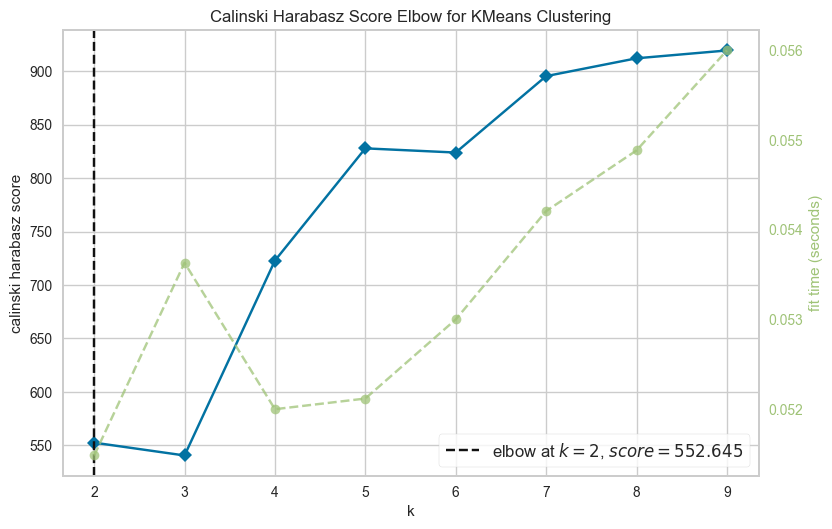

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

sc = KMeans(n_init=10)

pca_data_explained_var = pd.DataFrame(
    principalComponents,
    columns=pca_cols,
)

#O valor com a diminuiçao menos adrupta geralmente é o mais indicado
grafico_distortion = KElbowVisualizer(sc, k=(2,10) , metric='distortion')
grafico_distortion.fit(pca_data_explained_var.iloc[:,:2])
grafico_distortion.show()

grafico_silhouette = KElbowVisualizer(sc, k=(2,10) , metric='silhouette')
grafico_silhouette.fit(pca_data_explained_var.iloc[:,:2])
grafico_silhouette.show()

grafico_calinski_harabasz = KElbowVisualizer(sc, k=(2,10) , metric='calinski_harabasz')
grafico_calinski_harabasz.fit(pca_data_explained_var.iloc[:,:2])
grafico_calinski_harabasz.show()

## Construindo Cluster

In [32]:
from sklearn.pipeline import Pipeline
clustering = Pipeline(
    steps=[("PCA", PCA(n_components=2)),
            ("KMeans",KMeans(n_clusters=5 ,random_state=10))]
)

clustering.fit(df_hex_select[cluster_variables])

df_hex_select['clusters_KMeans'] = clustering['KMeans'].labels_
df_hex_select['clusters_KMeans'] = df_hex_select['clusters_KMeans'].astype(int)
df_hex_select['clusters_KMeans_string'] = df_hex_select['clusters_KMeans'].astype(str)


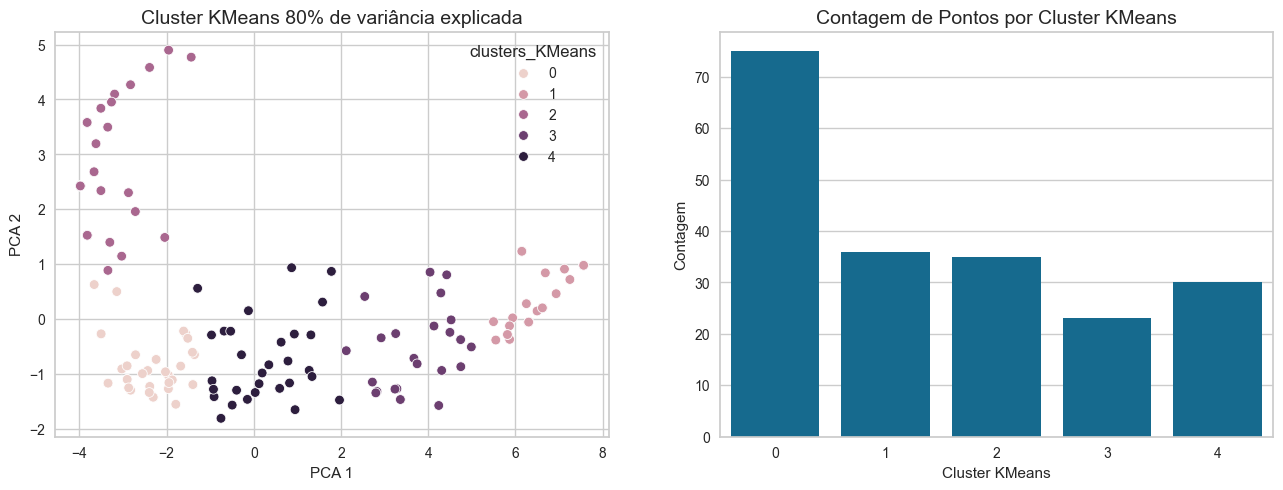

In [37]:
PCA_df = pd.DataFrame(principalComponents , columns=[f"PCA {x+1}" for x in np.arange(0,principalComponents.shape[1])])
PCA_df['clusters_KMeans'] = clustering['KMeans'].labels_


df_bar_plot_clusters = PCA_df[['PCA 1','clusters_KMeans']].groupby('clusters_KMeans',as_index=False).count()
df_bar_plot_clusters.columns = ['clusters_KMeans','count']

fig, ax = plt.subplots( 1,2, figsize=(14, 5))

sns.scatterplot(PCA_df , x="PCA 1",y="PCA 2" , hue='clusters_KMeans', ax=ax[0])
ax[0].set_title("Cluster KMeans 80% de variância explicada",fontsize=14)

sns.barplot(x="clusters_KMeans", y="count", data=df_bar_plot_clusters , ax=ax[1])
ax[1].set(xlabel="Cluster KMeans" , ylabel="Contagem")
ax[1].set_title("Contagem de Pontos por Cluster KMeans" , fontsize=14)

plt.show()

# Avaliando o cluster


## Gráfico de coordenadas paralelas por cluster

In [34]:
import plotly.express as px
parallel_means = df_hex_select[[
              "weighted_avg","clusters_KMeans"
               ]+cluster_variables].groupby('clusters_KMeans',as_index=False).mean()

parallel_means = parallel_means.sort_values('weighted_avg',ascending=False).reset_index(drop=True)
parallel_means['rank'] = parallel_means.index + 1
parallel_means['rank_str'] = parallel_means['rank'].astype(str)
parallel_means.columns = [col.replace("_aj","") for col in parallel_means.columns]
px.parallel_coordinates(parallel_means, color='rank',title="Pesos por cluster").show()


## GINI dos Clusters

Índice de Gini, é um instrumento para medir o grau de concentração em determinado grupo. O Coeficiente de Gini consiste em um número entre 0 e 1, onde 0 corresponde à completa igualdade e 1 corresponde à completa desigualdade (onde uma pessoa recebe todo o rendimento e as demais nada recebem). Levando em conta essa conceituação o que esperamos que após a clusterização as variáveis sejam mais "iguais" dentro de um cluster do que no contexto geral.

[Aqui um artigo que uso o conceito de gini para clusters.](https://www.researchgate.net/publication/305795188_Using_Gini_coefficient_to_determining_optimal_cluster_reporting_sizes_for_spatial_scan_statistics)

c:\WIMYD\choosen_house\process.py:251: RuntimeWarning:

invalid value encountered in scalar divide



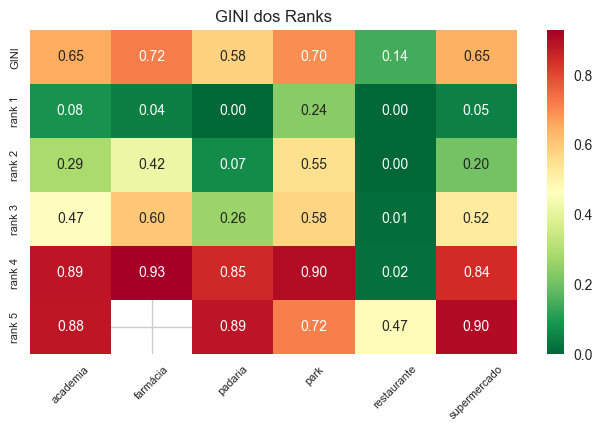

In [38]:
df_hex_select_plot = df_hex_select.merge(parallel_means[['clusters_KMeans','rank_str']],on='clusters_KMeans')
gini_db_cluster = evaluate_gini_clusters(df_hex_select_plot, 'rank_str', cluster_variables)
gini_db_cluster = gini_db_cluster[['Feature', 'GINI cluster 1', 'GINI cluster 2', 'GINI cluster 3','GINI cluster 4', 'GINI cluster 5', 'GINI']]
gini_db_cluster.columns = ['Feature', 'rank 1', 'rank 2', 'rank 3','rank 4', 'rank 5', 'GINI']
gini_db_cluster = gini_db_cluster.pivot_table(values=['rank 1', 'rank 2', 'rank 3','rank 4', 'rank 5', 'GINI'], index='Feature').T
gini_db_cluster.columns = [col.replace("_aj","") for col in gini_db_cluster.columns]


fig, ax_map = plt.subplots(figsize=(7, 4))
sns.heatmap(
    gini_db_cluster,
    annot=True,
    fmt='.2f',
    cmap="RdYlGn_r", #RdYlGn flare Greens
    annot_kws={"fontsize": 10},
    ax=ax_map  
)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8) 
plt.title("GINI dos Ranks")
plt.show()

# Mapa Final

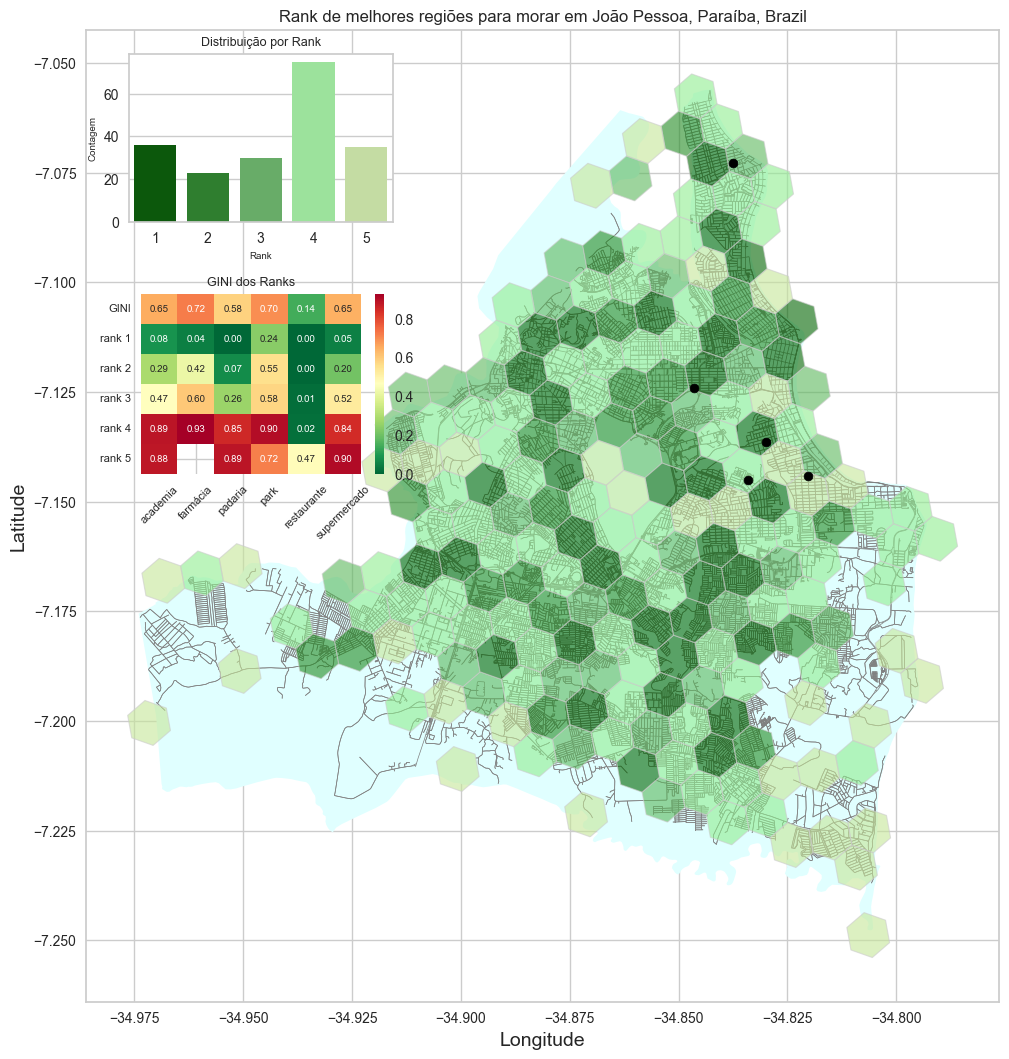

In [39]:

df_bar_plot_clusters_rank = df_hex_select_plot[['hex8_code','rank_str']].groupby('rank_str',as_index=False).count()
df_bar_plot_clusters_rank.columns = ['rank_str','count']


fig, ax_map = plt.subplots(figsize=(12, 12))

ax_map.set(title=f"Rank de melhores regiões para morar em {place_name}")
area.plot(ax=ax_map, color='lightcyan', linewidth=1, label='Area', zorder=1)
edges_proj.plot(ax=ax_map, color='gray', linewidth=0.5, label='Estradas', zorder=1  )

color_dict = {"1": "#006400", "2": "#228B22", "3": "#5CB85C", "4":"#90EE90" , "5":"#C6E699"}
df_hex_select_plot.plot(
        linewidth=0.8, ax=ax_map, edgecolor='0.8', legend=True, alpha=0.6 , color=df_hex_select_plot['rank_str'].map(color_dict))
enderecos_gpd.plot(ax=ax_map, color='black', linewidth=0.5, label='Endereços de interesse', zorder=1, markersize=40 , legend=True)


inset_width = 0.22  
inset_height = 0.14
inset_x = 0.17
inset_y = 0.72
inset_ax = fig.add_axes([inset_x, inset_y, inset_width, inset_height])
sns.barplot(ax=inset_ax, x="rank_str", y="count", data=df_bar_plot_clusters_rank , hue="rank_str" , palette=color_dict)
ax_map.set_xlabel('Longitude', size=14)
ax_map.set_ylabel('Latitude', size=14)
inset_ax.patch.set_facecolor('white') 
inset_ax.set_title('Distribuição por Rank', fontsize=9)  
inset_ax.set_xlabel('Rank', fontsize=7) 
inset_ax.set_ylabel('Contagem', fontsize=7)


inset_width_heatmap = 0.23  
inset_height_heatmap = 0.15  
inset_x_heatmap = 0.18
inset_y_heatmap = 0.51
inset_ax_heatmap = fig.add_axes([inset_x_heatmap, inset_y_heatmap, inset_width_heatmap, inset_height_heatmap])
sns.heatmap(
    gini_db_cluster,
    annot=True,
    fmt='.2f',
    cmap="RdYlGn_r",
    annot_kws={"fontsize": 7},
    ax=inset_ax_heatmap
)

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8) 

inset_ax_heatmap.patch.set_facecolor('white') 
inset_ax_heatmap.set_title('GINI dos Ranks', fontsize=9)  

plt.show()
